## Predicting Both Attributes: Continuous and Categorical Predictions

### Strategy:

1. **Import Relevant Packages:**
   - Ensure all necessary libraries are imported.

2. **Fetch Dataset:**
   - Obtain a dataset containing images of individuals, along with gender and age information.

3. **Create Training and Test Datasets:**
   - Perform appropriate preprocessing to divide the dataset into training and test sets.

4. **Build Model:**
   - Design a model with the following specifications:
     - Keep all layers similar to previous models, except for the last part.
     - Create two separate layers stemming from the preceding layer:
       - One layer for age estimation.
       - Another layer for gender classification.
     - Use different loss functions for each output branch:
       - Age estimation (continuous value): Mean Squared Error (MSE) or Mean Absolute Error (MAE).
       - Gender classification (categorical value): Cross-entropy loss.
     - Combine losses with a weighted summation.
     - Minimize overall loss through backpropagation to optimize weight values.

5. **Train Model and Predict:**
   - Train the model using the prepared datasets.
   - Utilize the trained model to make predictions on new images.


In [1]:
!pip install torchsummary


In [2]:
# 1. Import the relevant packages
import torch
import numpy as np
from tqdm import tqdm
import cv2
import os
import glob
import time
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets

# Check and set device to 'cuda' if available, else use 'cpu'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Display the selected device
print("Selected device:", device)

Selected device: cuda


In [5]:
# 2. Fetch the dataset
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate user
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Function to download a file from Google Drive
def get_file_from_drive(file_id, name):
    downloaded = drive.CreateFile({'id': file_id})
    downloaded.GetContentFile(name)

# Download the required dataset files
get_file_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
get_file_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
get_file_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

# Unzip the dataset
!unzip -qq fairface-img-margin025-trainval.zip


In [6]:
# 3. Load and structure the downloaded dataset

# Read the training and validation datasets
train_df = pd.read_csv('/content/fairface-label-train.csv')
val_df = pd.read_csv('/content/fairface-label-val.csv')

# Display the first few rows of the training dataset
train_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [7]:
# 4. Build the GenderAgeClass class that takes a filename as input and returns the corresponding image, gender, and scaled age
IMAGE_SIZE = 224

class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, ix):
        f = self.df.loc[ix]
        file = f.file
        if not os.path.exists(file):
            raise Exception(f"Image file '{file}' does not exist.")
        gen = f.gender == 'Female'
        age = f.age
        im = cv2.imread(file)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        im = self.preprocess_image(im)
        return im, age, gen

    def preprocess_image(self, im):
        im = cv2.resize(im, (IMAGE_SIZE, IMAGE_SIZE))
        im = torch.tensor(im).permute(2, 0, 1)
        im = self.normalize(im / 255.)
        return im

    def collate_fn(self, batch):
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            ims.append(im[None])
            ages.append(float(int(age) / 80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)
        return ims, ages, genders

In [8]:
# 5. Define the training and validation datasets and data loaders

# Create the datasets
trn_dataset = GenderAgeClass(train_df)
val_dataset = GenderAgeClass(val_df)

# Define data loaders
batch_size = 32
train_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=trn_dataset.collate_fn)
test_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Get a batch from the training loader
ims, ages, genders = next(iter(train_loader))
print(f"Batch Shape: Images - {ims.shape}, Ages - {ages.shape}, Genders - {genders.shape}")


Batch Shape: Images - torch.Size([32, 3, 224, 224]), Ages - torch.Size([32]), Genders - torch.Size([32])


In [9]:
# 6. Define the model, loss function, and optimizer
def get_model():
    # Load pre-trained VGG16 model
    model = models.vgg16(weights='IMAGENET1K_V1')

    # Freeze parameters
    for param in model.parameters():
        param.requires_grad = False

    # Replace avgpool layer
    model.avgpool = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
        nn.MaxPool2d(kernel_size=2),
        nn.ReLU(),
        nn.Flatten()
    )

    # Define custom classifier
    class AgeGenderClassifier(nn.Module):
        def __init__(self):
            super(AgeGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(in_features=2048, out_features=512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(in_features=512, out_features=128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128, 64),
                nn.ReLU()
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )

        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    # Replace classifier
    model.classifier = AgeGenderClassifier()

    # Define loss functions and optimizer
    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)

    return model.to(device), loss_functions, optimizer

In [10]:
# Define and initialize the model, loss functions, and optimizer
model, loss_functions, optimizer = get_model()

# Display a summary of the model
input_size = (3, 224, 224)

# Print a summary of the model architecture
summary(model, input_size=input_size, device=device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 178MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [11]:
# 7. Define the function to train on a batch of data and validate on a batch of the dataset.
def train_batch(data, model, optimizer, criteria):
    """
    Train the model on a batch of data.

    Args:
        data (tuple): Tuple containing input images (ims), age labels (age), and gender labels (gender).
        model (torch.nn.Module): The neural network model.
        optimizer (torch.optim.Optimizer): The optimizer for updating model parameters.
        criteria (tuple): Tuple of loss functions for gender and age.

    Returns:
        torch.Tensor: Total loss for the batch.
    """
    # Set the model to training mode
    model.train()

    # Unpack the data
    ims, age, gender = data

    # Zero the gradients in the optimizer
    optimizer.zero_grad()

    # Forward pass to get predictions
    pred_gender, pred_age = model(ims)

    # Unpack the loss functions
    gender_criterion, age_criterion = criteria

    # Compute gender and age losses
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)

    # Calculate the total loss as the sum of gender and age losses
    total_loss = gender_loss + age_loss

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    return total_loss

def validate_batch(data, model, criteria):
    """
    Validate the model on a batch of data.

    Args:
        data (tuple): Tuple containing input images (ims), age labels (age), and gender labels (gender).
        model (torch.nn.Module): The neural network model.
        criteria (tuple): Tuple of loss functions for gender and age.

    Returns:
        tuple: Tuple containing total loss, gender accuracy, and age mean absolute error (MAE).
    """
    # Set the model to evaluation mode
    model.eval()

    # Unpack the data
    ims, age, gender = data

    # Disable gradient computation during inference
    with torch.inference_mode():
        pred_gender, pred_age = model(ims)

    # Unpack the loss functions
    gender_criterion, age_criterion = criteria

    # Compute gender and age losses
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)

    # Calculate the total loss as the sum of gender and age losses
    total_loss = gender_loss + age_loss

    # Convert predicted gender probabilities to binary predictions (0 or 1)
    pred_gender_binary = (pred_gender > 0.5).squeeze()

    # Calculate gender accuracy
    gender_acc = (pred_gender_binary == gender).float().sum()

    # Calculate age mean absolute error (MAE)
    age_mae = torch.abs(age - pred_age).float().sum()

    return total_loss, gender_acc, age_mae


In [12]:
def train_model(n_epochs, train_loader, test_loader, model, optimizer, criteria):
    val_gender_accuracies = []
    val_age_maes = []
    train_losses = []
    val_losses = []
    best_test_loss = 1000
    start = time.time()

    # Loop through epochs
    for epoch in range(n_epochs):
        epoch_train_loss, epoch_test_loss = 0, 0
        val_age_mae, val_gender_acc, ctr = 0, 0, 0

        # Training loop
        for data in tqdm(train_loader, desc=f"Training epoch {epoch+1}/{n_epochs}"):
            loss = train_batch(data, model, optimizer, criteria)
            epoch_train_loss += loss.item()

        # Validation loop
        for data in tqdm(test_loader, desc=f"Validating epoch {epoch+1}/{n_epochs}"):
            loss, gender_acc, age_mae = validate_batch(data, model, criteria)
            epoch_test_loss += loss.item()
            val_age_mae += age_mae
            val_gender_acc += gender_acc
            ctr += len(data[0])

        val_age_mae /= ctr
        val_gender_acc /= ctr
        epoch_train_loss /= len(train_loader)
        epoch_test_loss /= len(test_loader)
        elapsed = time.time() - start
        best_test_loss = min(best_test_loss, epoch_test_loss)

        # Display progress
        remaining_time = (n_epochs - epoch) * (elapsed / (epoch + 1))
        print(f'{epoch + 1}/{n_epochs} ({elapsed:.2f}s - {remaining_time:.2f}s remaining)')

        # Display training and validation metrics
        info = (f'Epoch: {epoch + 1:03d}\tTrain Loss: {epoch_train_loss:.3f}\t'
                f'Test: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}\n'
                f'Gender Accuracy: {val_gender_acc * 100:.2f}%\tAge MAE: {val_age_mae:.2f}\n')
        print(info)

        # Append metrics for plotting
        val_gender_accuracies.append(val_gender_acc)
        val_age_maes.append(val_age_mae)

    return val_gender_accuracies, val_age_maes, train_losses, val_losses

In [13]:
# 8. Train the model over five epochs
# Set the number of epochs
n_epochs = 5

# Initialize the model, loss criteria, and optimizer
model, criteria, optimizer = get_model()

# Train the model and obtain performance metrics
val_gender_accuracies, val_age_maes, train_losses, val_losses = train_model(
    n_epochs=n_epochs,
    train_loader=train_loader,
    test_loader=test_loader,
    model=model,
    optimizer=optimizer,
    criteria=criteria
)

Validating epoch 1/5: 100%|██████████| 343/343 [01:22<00:00,  4.17it/s]


1/5 (736.84s - 3684.20s remaining)
Epoch: 001	Train Loss: 0.548	Test: 0.461	Best Test Loss: 0.4613
Gender Accuracy: 83.84%	Age MAE: 6.12



Validating epoch 2/5: 100%|██████████| 343/343 [01:21<00:00,  4.20it/s]


2/5 (1486.30s - 2972.61s remaining)
Epoch: 002	Train Loss: 0.399	Test: 0.455	Best Test Loss: 0.4547
Gender Accuracy: 84.03%	Age MAE: 6.27



Validating epoch 3/5: 100%|██████████| 343/343 [01:21<00:00,  4.20it/s]


3/5 (2234.14s - 2234.14s remaining)
Epoch: 003	Train Loss: 0.280	Test: 0.529	Best Test Loss: 0.4547
Gender Accuracy: 84.05%	Age MAE: 6.21



Validating epoch 4/5: 100%|██████████| 343/343 [01:21<00:00,  4.20it/s]


4/5 (2980.06s - 1490.03s remaining)
Epoch: 004	Train Loss: 0.197	Test: 0.630	Best Test Loss: 0.4547
Gender Accuracy: 83.86%	Age MAE: 6.42



Validating epoch 5/5: 100%|██████████| 343/343 [01:21<00:00,  4.19it/s]

5/5 (3718.49s - 743.70s remaining)
Epoch: 005	Train Loss: 0.159	Test: 0.709	Best Test Loss: 0.4547
Gender Accuracy: 83.64%	Age MAE: 6.30



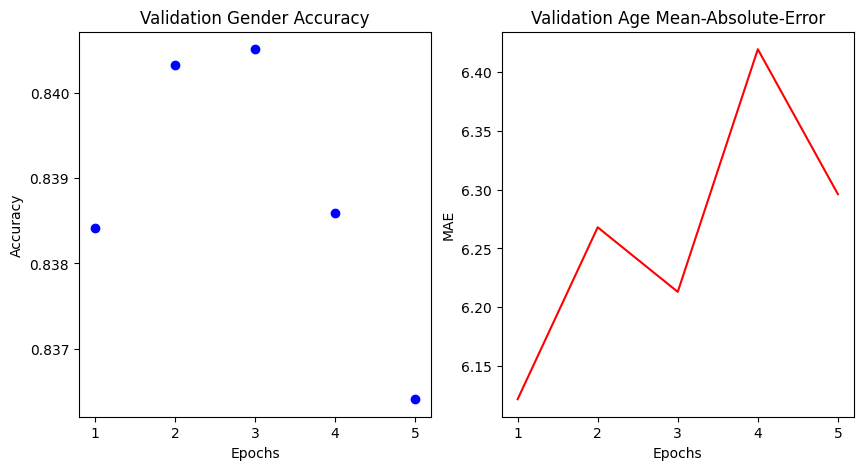

In [14]:
# 9. Plot the accuracy of age estimation and gender prediction over increasing epochs

# Generate array of epochs
epochs = np.arange(1, len(val_gender_accuracies) + 1)

# Create subplots for gender accuracy and age MAE
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax = ax.flat

# Move tensors to CPU before converting to NumPy arrays
val_gender_accuracies_np = [item.cpu().numpy() for item in val_gender_accuracies]
val_age_maes_np = [item.cpu().numpy() for item in val_age_maes]

# Plot validation gender accuracies
ax[0].plot(epochs, val_gender_accuracies_np, 'bo')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Validation Gender Accuracy')

# Plot validation age mean-absolute-error
ax[1].plot(epochs, val_age_maes_np, 'r')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('MAE')
ax[1].set_title('Validation Age Mean-Absolute-Error')

# Display the plots
plt.show()


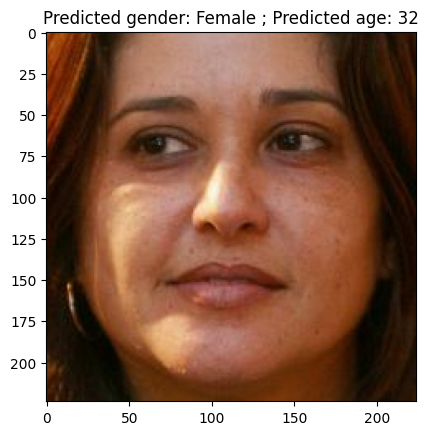

In [19]:
# 10. Make a prediction of age and gender on a random test image
# Load the image and pass it through the preprocess_image
im = cv2.imread('/content/val/10005.jpg')
prep_im = trn_dataset.preprocess_image(im)

# Switch to inference mode for the model
with torch.inference_mode():
    gender, age = model(prep_im.unsqueeze(0).to(device))

# Convert predictions to NumPy arrays
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()

# Display predicted gender and age
predicted_gender = 'Male' if pred_gender[0][0] < 0.5 else 'Female'
predicted_age = int(pred_age[0][0] * 80)
title = f'Predicted gender: {predicted_gender} ; Predicted age: {predicted_age}'

# Plot the image along with printing the predicted values
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.title(title)
plt.show()